In [4]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import numpy as np

import achiralqw as aqw

from achiralqw.graph import QWGraph, QWGraphBuilder as qwgb
from achiralqw.plotter import plot_qwgraph
from achiralqw.trends import plot_standard_progression
from achiralqw.analyze import TransportParameters
from achiralqw.collection import QWGraphList, CollectionBuilder, CachedQWGraphCollection

In [6]:
# It is often useful to analyze a bunch o related or unrelated graph alltogether using the same transport cryteria
#
# A QWGraphCollection is and abtract object meant to be an object that once given some TransportParameters and a group of graph
# automatize the most common operation

# An implementation of this object is found in QWGraphList which has the interface of a regular List(not really fully implemented tho, yet)

In [11]:

tp = TransportParameters(evt_mode = "first", opt_mode = "smart", solver_mode= "eigen")
gr_list = QWGraphList(tp = tp, name = "my_list")

gr = qwgb.Ring(3)
gr_list.append(gr)
gr = qwgb.Line(8)
gr_list.append(gr)
gr = qwgb.SquareCut(3)
gr_list.append(gr)
gr = qwgb.Ring(10)
gr_list.append(gr)
gr = qwgb.Ring(5).chain(4, HANDLES=True)
gr_list.append(gr)

In [15]:
# By evaluating a family of graphs we mean consider the performance_best() relative to each element
# the method evaluate will return two lists containing the required (x, performance) coordinates, ready for plotting

# NOTE: A QWGraph collection supports DIY multiprocess evaluation of performance_best(). 
# My konwledge of multiprocessing sucks and those items will ultimately hoard on your resources. 
# No guarantee of stability hehe

perf = gr_list.evaluate(target = "p", x_mode="dist")
print("Transport distance:\n\t",perf[0])
print("Transport performance:\n\t",perf[1])

my_list : Starting pool evaluation with 16 process
Evaluation


100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


Transport distance:
	 [1, 7, 1, 5, 10]
Transport performance:
	 [1.         0.85415631 1.         0.55973547 0.39794794]


In [7]:
# In our work we mainly focuse on a limited number of standarg graph families  
# The class CollectionBuilder allows one to quickly create a collection of the member of one of those families, namely:
#   - P(ath graphs)
#   - C (ring graphs)
#   - Ch (ring with handles)

# NOTE: A CollectionBuilder supports DIY multiprocess graph creation of collection. 
# My konwledge of multiprocessing sucks and those items will ultimately hoard on your resources. 
# No guarantee of stability hehe

tp = TransportParameters(evt_mode = "first", opt_mode = "smart", solver_mode= "eigen")
cb = CollectionBuilder()


In [8]:

# all progression which have a defined creation function just require a TransporParameters and a way to select the member to be created
# this can be done in two ways specifying differenct:
#   - select : List[int] (specify the element one by one)
#   - bouds : Tuple[int,int] + step : Optional|int (they will be fed to numpy.arange to create the selection list)
# if both are specified select has priority over bounds specifications 

lines = cb.P_progression( bounds=(4,30), step = 5, tp = tp)
print(lines)

rings = cb.C_progression( select= [2,3,5,7,11,13,17,19], tp = tp)
print(rings)

P progression: Starting pool creation with 16 process


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


P4 P9 P14 P19 P24 P29 
C progression: Starting pool creation with 16 process


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


C2 C3 C5 C7 C11 C13 C17 C19 


In [8]:
# chain creation is also automated

unit = qwgb.Ring(4)

chains = cb.chain_progression(gr_unit= unit, bounds = (5,20), tp = tp, HANDLES = True)
print(chains)


C4 chain progression: Starting pool creation with 16 process


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


h(C4^2) h(C4^3) h(C4^4) h(C4^5) h(C4^6) h(C4^7) h(C4^8) h(C4^9) 


In [9]:
# on top of that you can also specify a custom creation function for the collection
# The function must have the signature f( i : int) -> QWgraph, x>0,  giving back the i-th member of the family of graphs.
# NOTE:
#   the function has to be defined somewhere in a script(pickling local notebook function is problematic)

from setup_cache import SC_chain

a = SC_chain(3)
print(a.code)

squares = cb.from_list(cb.build_gr_list(create_func= SC_chain, input_vec= [x for x in range(2,7)]))
print(squares)

h(DiC4^3)
P progression: Starting pool creation with 16 process


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


h(DiC4^2) h(DiC4^3) h(DiC4^4) h(DiC4^5) h(DiC4^6) 


P progression: Starting pool creation with 16 process


100%|██████████| 23/23 [00:18<00:00,  1.26it/s]


P5 : Starting pool evaluation with 16 process
Evaluation


100%|██████████| 23/23 [00:24<00:00,  1.07s/it]


m:  0.519594819049538  +-  0.000940910458651665
q:  1.4663996799447414  +-  ????
r:  0.9999655702525155
P5 : Starting pool evaluation with 16 process
Evaluation


100%|██████████| 23/23 [00:22<00:00,  1.01it/s]


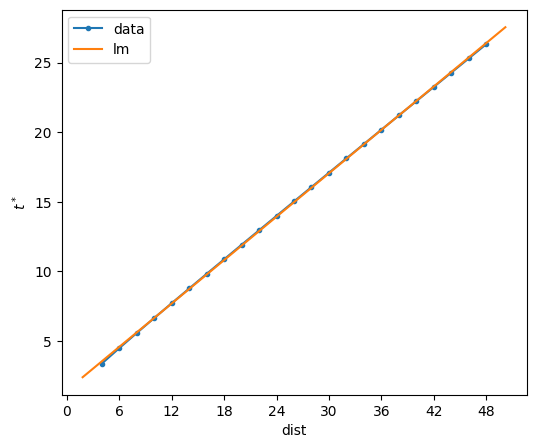

In [17]:
# A QWGraph collection also support a selection of standard (standard here stands for arbitrary) transport behaviour modelling
bounds = (5,50)
tp = TransportParameters(evt_mode = "first", opt_mode = "none", solver_mode= "eigen")
lines = cb.P_progression( bounds = bounds, step = 2, tp = tp)

#fit transport time to a linear 1
params = lines.transport_time_lm()
def lm(x):
    return params[0]*x + params[1]

ax = plot_standard_progression(lines, target="t", label= "data")
lims = ax.get_xlim()
ax.plot([lims[0],lims[1]], [lm(lims[0]), lm(lims[1])], label =  "lm")
ax.legend()

In [21]:
# morover you can also fit your tata with some questionable polynomial models

poly_params = lines.transport_prob_model( mode = "poly")
b1_params = lines.transport_prob_model(mode = "banchi1") 
b2_params = lines.transport_prob_model(mode = "banchi2")
x, c4data = lines.evaluate()

######### Transpor prob model:  poly
P5 : Starting pool evaluation with 16 process
Evaluation


100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


ax^2:  -0.0744916336996329
bx:  0.0646155720074873
c:  -0.0029426549592976316
######### Transpor prob model:  banchi1
P5 : Starting pool evaluation with 16 process
Evaluation


100%|██████████| 23/23 [00:24<00:00,  1.09s/it]


a*x^-2/3:  3.6077269767517097  +-  0.0474254379083727
######### Transpor prob model:  banchi2
P5 : Starting pool evaluation with 16 process
Evaluation


100%|██████████| 23/23 [00:23<00:00,  1.03s/it]


a*x^-2/3:  5.804977867141865  +-  0.010087314522929497
b*x^-4/3:  -9.053176189743489  +-  0.14169600949962155
P5 : Starting pool evaluation with 16 process
Evaluation


100%|██████████| 23/23 [00:26<00:00,  1.17s/it]


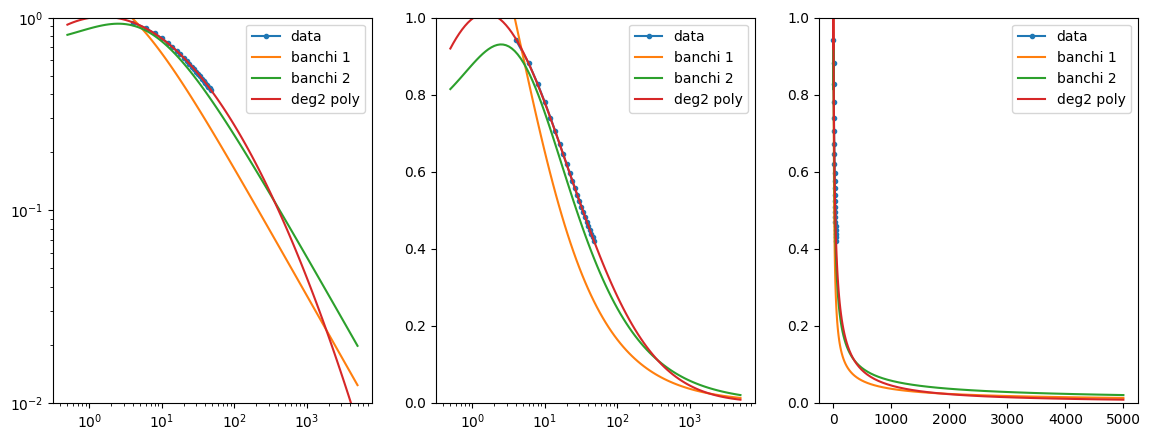

In [23]:
fig, axx = plt.subplots(1,3, figsize = (14,5))

axx[0].plot(x,c4data, marker = ".", label = "data")
axx[1].plot(x,c4data, marker = ".", label = "data")
axx[2].plot(x,c4data, marker = ".", label = "data")

axx[0].set_xscale("log")
axx[0].set_yscale("log")
axx[0].set_ylim(.01,1)

axx[1].set_ylim(0,1)
axx[1].set_xscale("log")

axx[2].set_ylim(0,1)

sample = np.geomspace(bounds[0]/10, bounds[1]*100, 100)

def b1(x,a ):
    return a*np.power(x+3, -2/3)
def b2(x,a,b ):
    return a*np.power(x+3, -2/3) + b*np.power(x+3, -4/3)

def poly_model(x,a,b,c):
    return np.exp(a*(np.log(x)**2) + b*np.log(x) + c)


b1_data = [b1(x, *b1_params) for x in sample]
axx[0].plot(sample, b1_data, label = "banchi 1")
axx[1].plot(sample, b1_data, label = "banchi 1")
axx[2].plot(sample, b1_data, label = "banchi 1")

b2_data = [b2(x, *b2_params) for x in sample]
axx[0].plot(sample, b2_data, label = "banchi 2")
axx[1].plot(sample, b2_data, label = "banchi 2")
axx[2].plot(sample, b2_data, label = "banchi 2")

poly_data = [poly_model(x, *poly_params) for x in sample]
axx[0].plot(sample, poly_data, label = "deg2 poly")
axx[1].plot(sample, poly_data, label = "deg2 poly")
axx[2].plot(sample, poly_data, label = "deg2 poly")


axx[0].legend()
axx[1].legend()
axx[2].legend()

In [12]:
# Having a couple of reference standard families of graphs it makes sense to have a way to store their relevant figures of merit
# 
# A CachedQWGraphCollection does just that
# It works just like a regular collection but needs a file to store and load data from and crucially a function that creates the graph of the family
# The function must have the signature f( i : int) -> QWgraph, x>0,  giving back the i-th member of the family of graphs.
# NOTE:
#   the function has to be defined somewhere in a script(pickling local notebook function is problematic)

# WARNING: this cell might take a while to run

from setup_cache import C3_chain

fast_params_C3 =     TransportParameters( solver_mode= "eigen", evt_mode = "first", opt_mode = "smart", diag = True)
fast_params_C3.fix_phase( gr = qwgb.Ring(3))

cached_C3   = CachedQWGraphCollection( create_func = C3_chain,      filename = "C3_chain_first_fast",   tp = fast_params_C3)

selection = np.arange(2, 50)

cached_C3.evaluate(selection)

#fast evaluation with cached data!!!
lm_test_range = [ np.arange(i*10, i*20) for i  in range(1, 3)]

for selection in lm_test_range:
    cached_C3.transport_time_lm(selection)

cached_C3.offload()

P progression: Starting pool creation with 16 process


100%|██████████| 48/48 [00:19<00:00,  2.46it/s]


C3_chain_first_fast : Starting pool evaluation with 16 process
Evaluation


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


m:  -0.006497509505679933  +-  1.532509475504242e-05
q:  1.0338204715892163  +-  ????
r:  -0.999977748566974
m:  -0.005436309428449468  +-  5.525155076560329e-05
q:  1.008003249904527  +-  ????
r:  -0.9990716365912279


In [14]:
# Once a cached collection is created one can load back the data specifying the filename and the family function
# Crucially the creation function must remain the same, unfortunately it's up to the user to mantain this coherence in the cache

cached_C3   = CachedQWGraphCollection( create_func = C3_chain,      filename = "C3_chain_first_fast")

#still super fast
for selection in lm_test_range:
    cached_C3.transport_time_lm(selection)

m:  -0.006497509505679933  +-  1.532509475504242e-05
q:  1.0338204715892163  +-  ????
r:  -0.999977748566974
m:  -0.005436309428449468  +-  5.525155076560329e-05
q:  1.008003249904527  +-  ????
r:  -0.9990716365912279
